## Optima TB Plotting2

Making plots in Optima TB is intrinsically difficult, because customization is required in several places

- Aggregating outputs by summation or averaging
- Aggregating outputs across populations
- Collapsing values over time
- Comparing outputs or pops within results, or comparing across results
- Stacking bars with groups of variables
- Setting colours for individual quantities, or sets of quantities
- Setting axis limits to focus on particular times or values
- Having legends together with the figure, or in a separate figure
- Optionally having names converted to long names 
- Setting custom axis labels and titles
- Saving output figures

This notebook provides documentation for the new plotting library, providing an overview of available functions and examples of how to perform common tasks


In [1]:
# IMPORTS
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('..')
from optima_tb.project import Project
from optima_tb.utils import odict
from optima_tb.plotting import plotResult
from optima_tb.defaults import defaultOptimOptions
import optima_tb.plotting as oplt
import optima_tb.plotting2 as oplt2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML

CSS = """
.output {
    flex-flow: row wrap;
}
"""

HTML('<style>{}</style>'.format(CSS))



Optima TB: a TB optimization and analysis tool
Copyright (C) 2017 by the Optima Consortium



Set the paths below to point to the location of the files on disk

In [2]:
cascade = '../../tb-ucl-analyses/south_africa/Cascadespreadsheets/cascade_south_africa_art.xlsx'
databook = '../../tb-ucl-analyses/south_africa/Databookspreadsheets/databook_south_africa.xlsx'

Now, run two simulations, so that we have a `ResultSet` corresponding to parameter results, and a `ResultSet` corresponding to program results.

In [3]:
proj = Project(name = 'south_africa', cascade_path = cascade, plotting_level = 'dev', validation_level = 'avert')
proj.loadSpreadsheet(databook_path = databook)
name = 'default'
proj.makeParset(name=name)
progset = proj.makeProgset(name=name)
options = defaultOptimOptions(settings=proj.settings, progset = proj.progsets[0])
par_results = proj.runSim(parset_name=name,plot=False)
prog_results = proj.runSim(parset_name=name, progset_name=name, options=options, plot=False)
par_results.name = 'Parset'
prog_results.name = 'Progset'
plt.rcParams['figure.figsize'] = (5,3)

26-03-18 11:54:18    INFO     Loading settings
26-03-18 11:54:18    INFO     Validation settings: avert
26-03-18 11:54:18    INFO     Loading plotting settings: dev
26-03-18 11:54:19    INFO     The cascade was validated successfully!
26-03-18 11:54:19    INFO     Created settings based on cascade: ../../tb-ucl-analyses/south_africa/Cascadespreadsheets/cascade_south_africa_art.xlsx
26-03-18 11:54:19    INFO     Created project: south_africa
26-03-18 11:54:19    INFO     Attempting to load databook ../../tb-ucl-analyses/south_africa/Databookspreadsheets/databook_south_africa.xlsx
26-03-18 11:54:20    WARNING  Please verify databook under Parameter: spd_infxness and population 0-4 as a number greater than 1 or negative number was entered for definition type "fraction" for Year: 2000, value entered: 11.0
26-03-18 11:54:20    WARNING  Please verify databook under Parameter: spd_infxness and population 15-64 as a number greater than 1 or negative number was entered for definition type "frac

### `PlotData objects`

Conceptually, there are 4 stages of plotting

1. Preparing data for plotting by aggregating e.g. summation, averaging
2. Rendering a standard plot
3. Applying customizations such as changing axis limits, modifying titles etc.
4. Saving an image of the plot to disk

Previously, all of these stages were controlled by arguments to a single function. However, this had two undesirable consequences

- The argument list for the plotting functions becomes very difficult to read because so many input options are available. This propagates into lower level functions as well. For example, `plotResult` has 16 arguments, `innerPlotTrend` has 19 arguments, and `_plotTrends` has **38** arguments. 
- The number of different possibilities for execution within the function makes it difficult to predict the consequences of changes made to the code, making the code more difficult to maintain and debug

The root cause of the problem is that plotting is fundamentally a difficult problem because a lot of customization _is_ essential. The single-function strategy attempts to simplify tasks for end users. While this works for individual tasks in isolation, when this strategy is scaled up to the whole system, it ends up making things more complicated for both developers and users. Further evidence that the existing strategy is not effective is that most plotting for applications is carried out in scripts like `plot_daru.py` which contains a number of application-specific plotting functions. The function calls to actually generate plots end up being calls to functions in the application's plotting module. As a result, even if the Optima TB plotting library separated some of the steps out, this would still be hidden from users within the application plotting functions. The application plotting functions could then play a greater role in making highly figure-specific customizations. 

We will now go through each of the 4 plotting stages in detail.

### Data preparation and aggregation

All plotting starts with the creation of a `PlotData` object. This object is distinct from a `ResultsSet` in three ways

- A `PlotData` object contains `Series` that are identified by a `[results,pops,outputs]` tuple. That is, it spans multiple results, which allows it to contain the relevant data for plotting scenarios
- A `Series` can be composed of multiple `Outputs` from a simulation. That is, it can contain quantities that are derived from transformations of simulation results, that are computed on a plot-specific basis
- A `Series` contains a specification of formatting options, such as color, which are not stored in a `ResultSet`

In sum, a `PlotData` object is a container for all of the data that appears on a plot. A `PlotData` object should be instantiated when a plot is about to be generated. A basic example is shown below

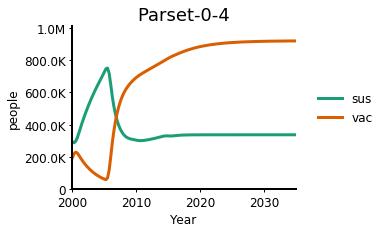

In [4]:
d = oplt2.PlotData(par_results,pops=['0-4'],outputs=['sus','vac'])
figs = oplt2.plotSeries(d)

Data in a `PlotData` object can be aggregated in one of three ways

- Aggregation over outputs (sum, average, or weighted average, where the weighting is based on source compartment size). Note that a weighted average cannot be used for output parameters with no associated transitions, because there is no compartment size associated with those quantities
- Aggregation over populations (sum, average, or weighted average, where the weighting is based on population size)
- Aggregation over time (sum, or average) 

We will discuss the first two (output and population aggregation) now, and show time aggregation below in the context of bar plots. 

First, when instantiating a `PlotData` object, you need to specify a list of `results`, `pops`, and `outputs` that you want to display on the plot. The `results` are mandatory, because a `ResultSet` is required to provide raw data. If not specified, by default `pops` is set to all of the populations in the `ResultSet` and `outputs` is set to all of the compartments. You can specify as many or as few as you like. 

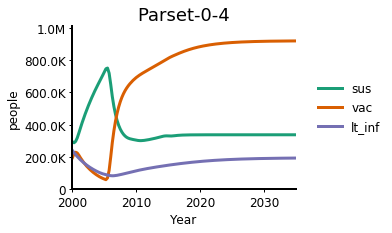

In [5]:
d = oplt2.PlotData(par_results,pops=['0-4'],outputs=['sus','vac','lt_inf'])
figs = oplt2.plotSeries(d)

As shown above, `pops` and `outputs` are specified as lists. If you want to specify an aggregation, instead of a string, pass in a dict where the key is name of your new aggregated output, and the value is the list of raw outputs to aggregate

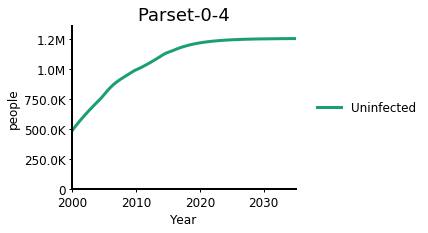

In [6]:
d = oplt2.PlotData(par_results,pops=['0-4'],outputs=[{'Uninfected':['sus','vac']}])
figs = oplt2.plotSeries(d)

You can mix and match aggregations and raw outputs

people


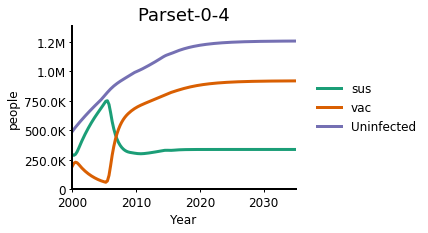

In [48]:
d = oplt2.PlotData(par_results,pops=['0-4'],outputs=['sus','vac',{'Uninfected':['sus','vac']}])
figs = oplt2.plotSeries(d)
print d.series[0].units

You can also aggregate across both outputs and pops. Output aggregations are performed first, followed by population aggregations. 

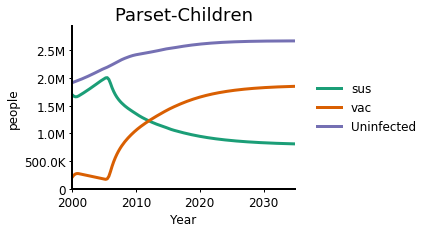

In [8]:
d = oplt2.PlotData(par_results,pops=[{'Children':['0-4','5-14']}],outputs=['sus','vac',{'Uninfected':['sus','vac']}])
figs = oplt2.plotSeries(d)

It is common to require aggregation over all populations. The special keyword `'all'` is provided for this purpose

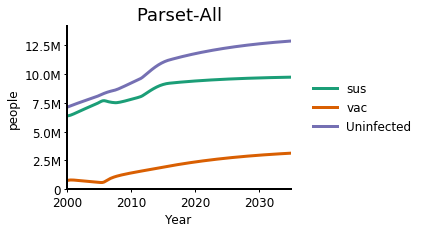

In [9]:
d = oplt2.PlotData(par_results,pops='all',outputs=['sus','vac',{'Uninfected':['sus','vac']}])
figs = oplt2.plotSeries(d)

By default, aggregation is performed by summing all of the values together. You can use the arguments `output_aggregation` and `pop_aggregation` to specify a different method. For example, to average the outputs:

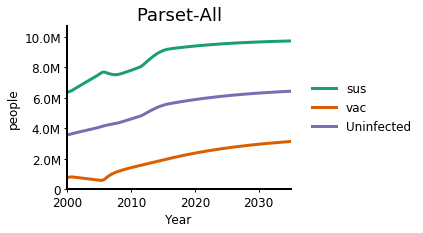

In [10]:
d = oplt2.PlotData(par_results,output_aggregation='average',pops='all',outputs=['sus','vac',{'Uninfected':['sus','vac']}])
figs = oplt2.plotSeries(d)

For outputs, a weighted average is based on compartment size (within populations), while for populations, a weighted average is based on the population size. The example below simply shows a weighted average of the compartment sizes, but in practice, the weighted average would be most useful for flow rates where the source compartment size is different to the flow rate.

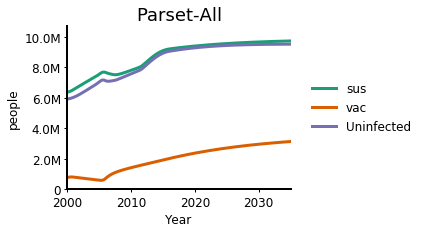

In [11]:
d = oplt2.PlotData(par_results,output_aggregation='weighted',pops='all',outputs=['sus','vac',{'Uninfected':['sus','vac']}])
figs = oplt2.plotSeries(d)

Some aggregations do not make sense. For instance, if you aggregate prevalances, they should be averaged, not summed. In cases where the code is able to identify this, a warning will be displayed:

### Function aggregations

As well as defining aggregations, you can also define transformations of simulation quantities using arbitrary functions. This can only be done for outputs. To do this, define an output quantity as a `dict()` but provide a string containing the function to be evaluated. For instance

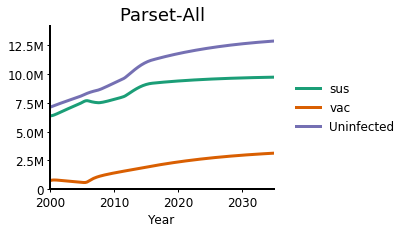

In [12]:
d = oplt2.PlotData(par_results,pops='all',outputs=['sus','vac',{'Uninfected':'sus+vac'}])
figs = oplt2.plotSeries(d)

The variables that can appear inside the function are

- Compartment labels
- Characteristic labels
- Parameter labels
- Link labels (transition tags) - in which case, the value used will be the annualized flow rate summed over duplicate links

These are always accessed within a population. Because you can specify any function supported by the parsing system, you can use a function aggregation to dynamically compute prevalances and other quantities requiring more sophisticated transformations of the outputs:

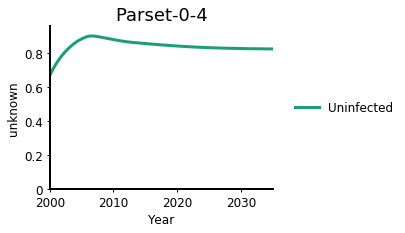

In [25]:
d = oplt2.PlotData(par_results,pops='0-4',outputs=[{'Uninfected':'(sus+vac)/alive'}])
figs = oplt2.plotSeries(d)

One thing to be careful of in general is that fraction quantities should be aggregating by averaging, not summing. So if we wanted to compute the overall fraction of uninfected individuals, the following is not correct:

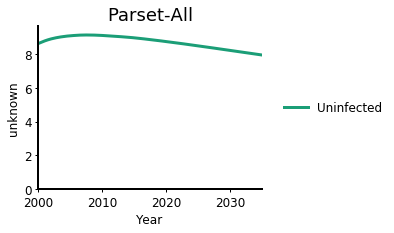

In [26]:
d = oplt2.PlotData(par_results,pops='all',outputs=[{'Uninfected':'(sus+vac)/alive'}])
figs = oplt2.plotSeries(d)

This is obviously incorrect because the value is greater than 1. Instead, we need to specify that we are averaging across populations. Because the populations have very different sizes, a popsize-weighted average would be most appropriate

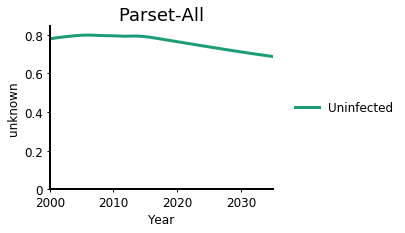

In [19]:
d = oplt2.PlotData(par_results,pops='all',outputs=[{'Uninfected':'(sus+vac)/alive'}],pop_aggregation='weighted')
figs = oplt2.plotSeries(d)

One final comment regards the units of the plot data. The `plotting2` functions will automatically display the units on the y-axis if the units for all of the data being plotted are the same. The possible units for various quantities are:

- `Compartment` : 'people'
- `Characteristic` : 'people' if no denominator, or '' (dimensionless) if there is a denominator
- `Parameter` : 'unknown' if not a transition parameter, otherwise 'fraction' or 'number'
- `Link` : 'people/year' if not time aggregated, 'people' otherwise

Output aggregations will have units that match the constituent quantities if they all have the same units, or 'unknown' if they have different units or if a function aggregation is used. See examples below

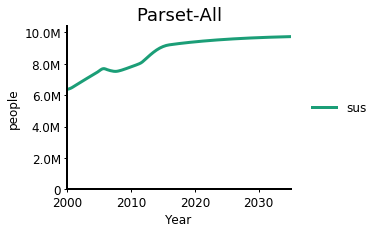

In [7]:
# Compartment units
d = oplt2.PlotData(par_results,pops='all',outputs=['sus'])
figs = oplt2.plotSeries(d)

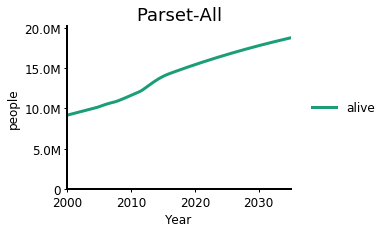

In [8]:
# Characteristic units
d = oplt2.PlotData(par_results,pops='all',outputs=['alive'])
figs = oplt2.plotSeries(d)

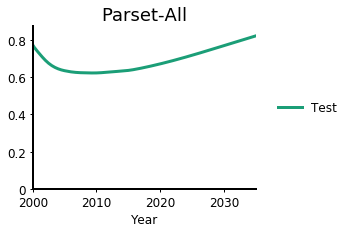

In [42]:
# Characteristic prevalance units (dimensionless)
d = oplt2.PlotData(par_results,pops='all',output_aggregation='average',pop_aggregation='average',outputs=[{'Test':['lt_prev','spd_prev']}])
figs = oplt2.plotSeries(d)

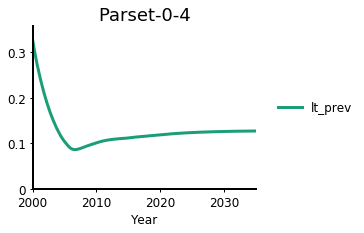

In [44]:
# Characteristic prevalance units (dimensionless)
d = oplt2.PlotData(par_results,pops='0-4',outputs=['lt_prev'])
figs = oplt2.plotSeries(d)

26-03-18 12:11:11    WARNING  Warning - output "v_rate" is not in number units, so population aggregation probably should not be "sum"


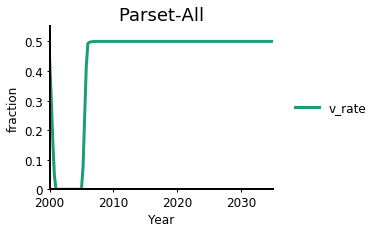

In [47]:
# Transition parameter units
d = oplt2.PlotData(par_results,pops='all',outputs=['v_rate'])
figs = oplt2.plotSeries(d)

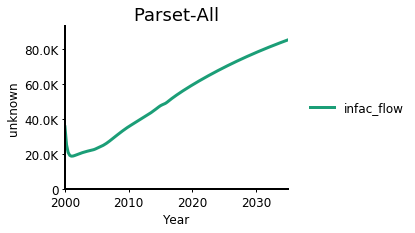

In [11]:
# Non-transition parameter units
d = oplt2.PlotData(par_results,pops='all',outputs=['infac_flow'])
figs = oplt2.plotSeries(d)

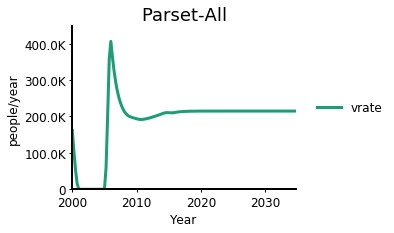

In [12]:
# Actual flow rate
d = oplt2.PlotData(par_results,pops='all',outputs=['vrate'])
figs = oplt2.plotSeries(d)

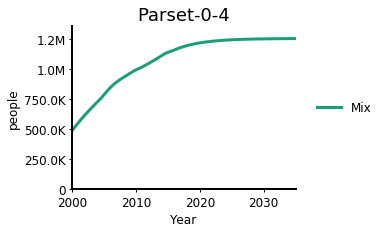

In [34]:
# Matched normal aggregation
d = oplt2.PlotData(par_results,pops='0-4',outputs=[{'Mix':['sus','vac']}])
figs = oplt2.plotSeries(d)

26-03-18 11:57:29    WARNING  Warning - aggregation for output "Mix" is mixing units, this is almost certainly not desired


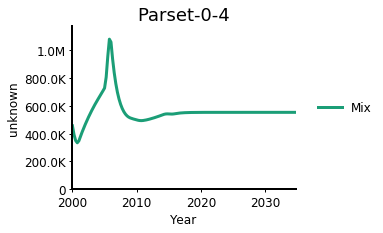

In [22]:
# Mixed normal aggregation
d = oplt2.PlotData(par_results,pops='0-4',outputs=[{'Mix':['sus','vrate']}])
figs = oplt2.plotSeries(d)

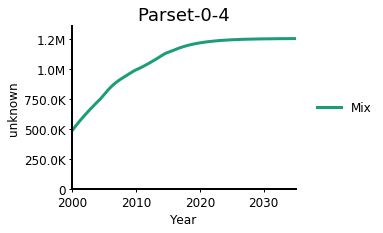

In [24]:
# Matched function aggregation - note that units are 'unknown' even though the units match
# because we aren't able to keep track of units inside the arbitrary function
d = oplt2.PlotData(par_results,pops='0-4',outputs=[{'Mix':'sus+vac'}])
figs = oplt2.plotSeries(d)

### Plotting series


A number of options are available when plotting a time series. First, `PlotData` is a 4-dimensional quantity - a data point is uniquely identified based on `result`, `pop`, `output` and `time`. For a time series plot, the x-axis is always the time dimension. Then, you can select whether separate lines on the plot should be drawn for `results`, `pops`, or `outputs`, by using the `axis` argument to `plotSeries`. Finally, `plotSeries` will display a separate figure for each of the remaining dimensions. The example below has a `PlotData` object containing 2 results, 2 pops, and 2 outputs, and shows the effect of setting the `axis` property to each of the possible options:

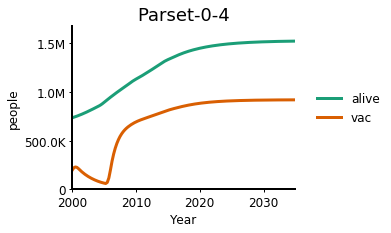

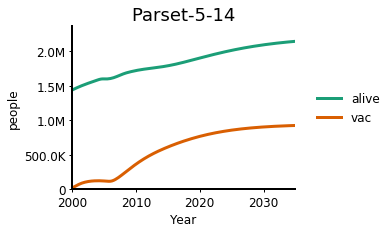

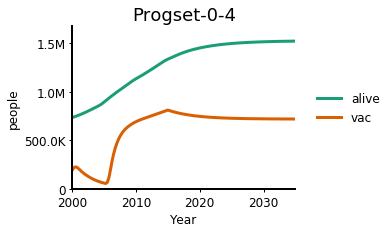

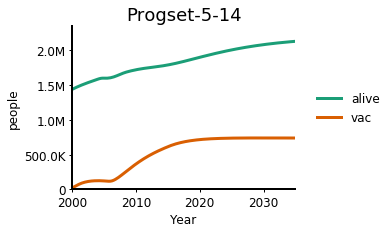

In [16]:
# Compare outputs on the plot
d = oplt2.PlotData([par_results,prog_results],pops=['0-4','5-14'],outputs=['alive','vac'])
figs = oplt2.plotSeries(d,axis='outputs')

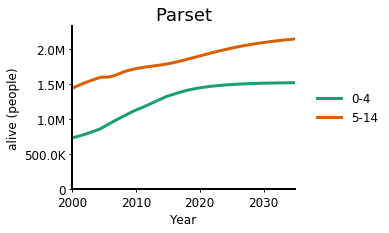

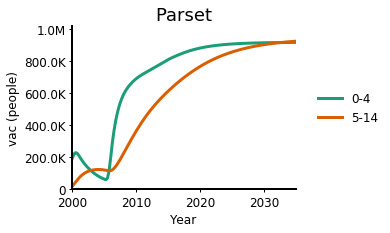

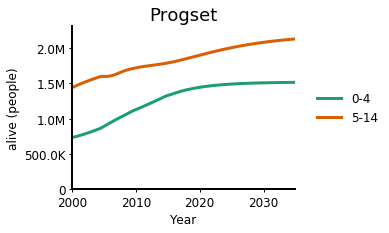

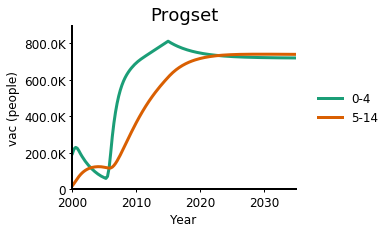

In [17]:
# Compare populations on the plot
#
# Note how we are reusing the PlotData instance (d)
# because we are only generating a different view
# of the same data
figs = oplt2.plotSeries(d,axis='pops')

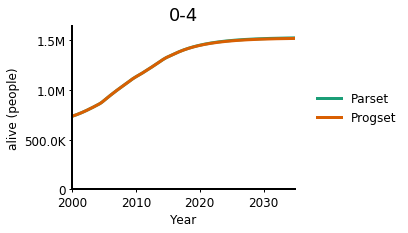

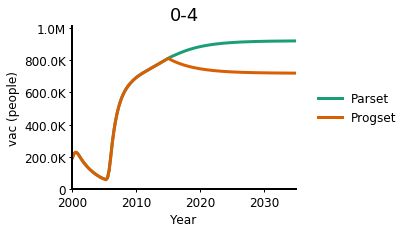

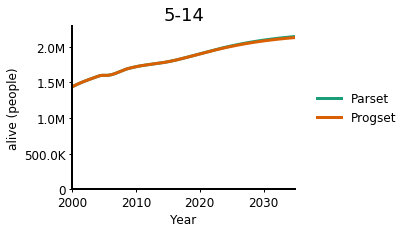

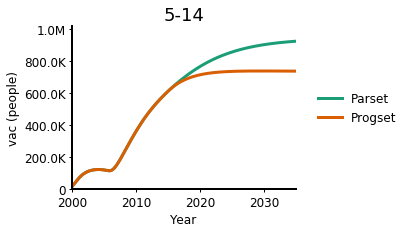

In [18]:
# Compare results on the plot (e.g. for scenarios)
figs = oplt2.plotSeries(d,axis='results')

Another common task is superimposing data on the plot. This can be done by passing a `Data` dict to `plotSeries`. Typically, this is just `proj.data` . If data does not exist, then it will not be plotted (e.g. in the example below, data is available for `alive` but not for `vac`)

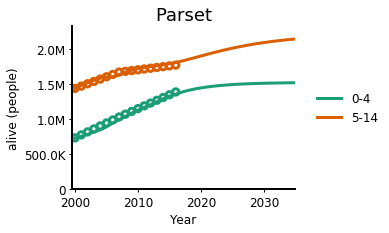

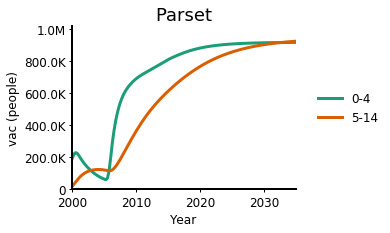

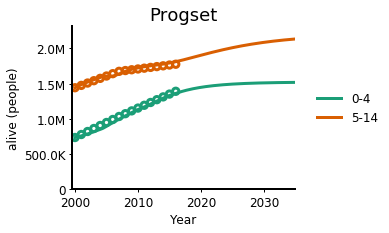

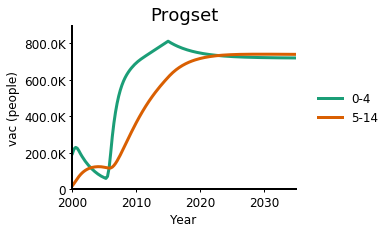

In [19]:
figs = oplt2.plotSeries(d,axis='pops',data=proj.data)

For publications, you might want to have the legend displayed on a separate figure. This can be done by setting `separate_legend=True` 

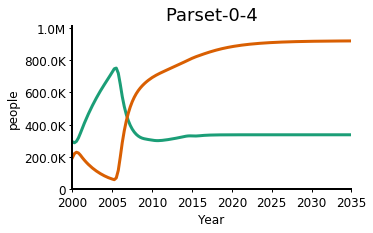

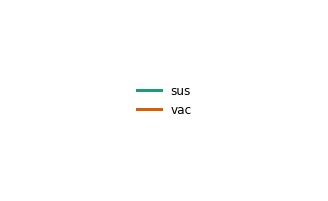

In [20]:
d = oplt2.PlotData(par_results,pops=['0-4'],outputs=['sus','vac'])
figs = oplt2.plotSeries(d,separate_legend=True)

Finally, there are three types of plots

- Line plots (as shown above)
- Stacked plots
- Stacked plots, normalized to unit height (to show relative proportions)

These can be set using the `plot_type` argument

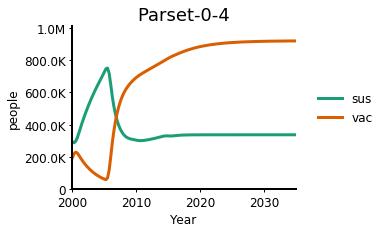

In [21]:
d = oplt2.PlotData(par_results,pops=['0-4'],outputs=['sus','vac'])
figs = oplt2.plotSeries(d,plot_type='line')

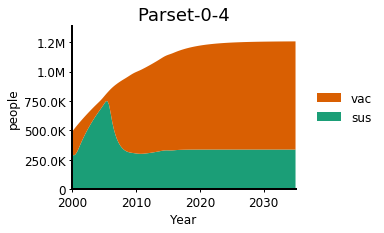

In [22]:
figs = oplt2.plotSeries(d,plot_type='stacked')

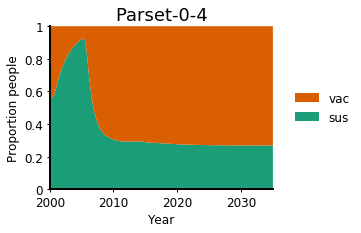

In [23]:
figs = oplt2.plotSeries(d,plot_type='proportion')

The stacking order is determined by the order that the quantities are specified when instantiating the `PlotData` object. The bottom-most color on the plot is the quantity that appears first in the list. For example

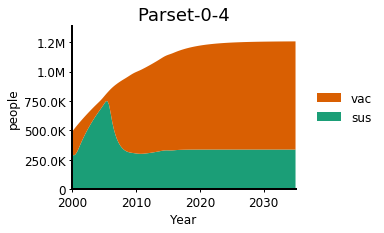

In [24]:
d = oplt2.PlotData(par_results,pops=['0-4'],outputs=['sus','vac'])
figs = oplt2.plotSeries(d,plot_type='stacked')

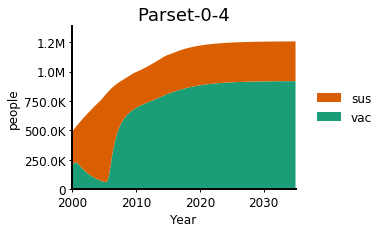

In [25]:
d = oplt2.PlotData(par_results,pops=['0-4'],outputs=['vac','sus'])
figs = oplt2.plotSeries(d,plot_type='stacked')

### Plotting transition parameters and flow rates

Every transition in the model is governed by a `Link` object, which derives its value from a `Parameter`. A `Parameter` object may supply values for multiple `Links` (e.g. `doth_rate` supplies death by other causes for multiple compartments). A `Parameter` may be in units of fraction or number, while a `Link` is always in units of `number`. A `Link` is identified by its transition tag, which appears in the cascade transition matrix, while a `Parameter` is identified by its own label. 

If you want to plot a `Parameter`, the `output` label should be the parameter's label, while if you want to plot an actual flow rate, the `output` label should be a transition tag. If you specify a transition tag, the values will automatically be summed over duplicate links and annualized. In both cases, if you specify that data should be plotted, the data will be accessed based on the `Parameter` label. This is illustrated below:

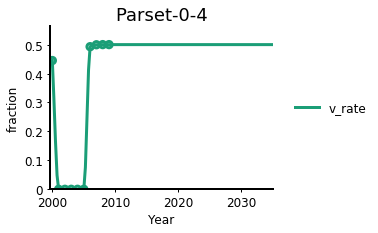

In [26]:
d = oplt2.PlotData(par_results,pops=['0-4'],outputs=['v_rate'])
figs = oplt2.plotSeries(d,data=proj.data)

Here, `v_rate` is a Parameter label, so the value being plotted is for the transition parameter which here was defined in fraction units. The data points correspond to this same data.

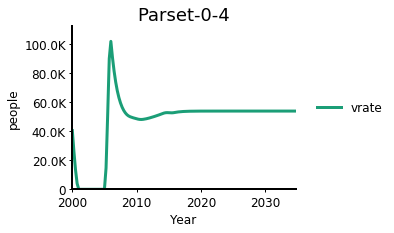

In [94]:
d = oplt2.PlotData(par_results,pops=['0-4'],outputs=['vrate'])
figs = oplt2.plotSeries(d,data=proj.data)

Now, `vrate` is the transition derived from `v_rate`. Therefore, it is in units of `people/year`. Note that the data points have been plotted, but because the data were specified as fraction units, the values all appear close to `0`. In this case, it would not be appropriate to superimpose the data, whereas if the data were specified in number units, it would be fine. 

### Setting full names

Renaming outputs is performed by setting the `result_name`, `pop_name` and `output_name` attributes in the `PlotData` object, which map the short names (e.g. `sus`) to long names. Most commonly, this is used to display full names from the `project` object. To use full names, pass a `project` object to the `PlotData` constructor. This will set the `*_name` properties appropriately. For example

{'Parset': 'Parset'}
{'0-4': 'Gen 0-4'}
{'vac': 'Vaccinated', 'sus': 'Susceptible'}


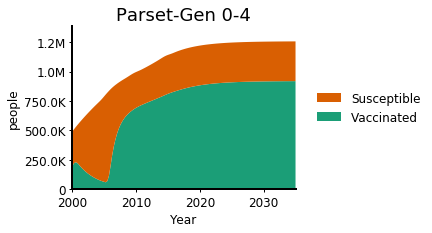

In [28]:
d = oplt2.PlotData(par_results,pops=['0-4'],outputs=['vac','sus'],project=proj)
print d.result_names
print d.pop_names
print d.output_names
figs = oplt2.plotSeries(d,plot_type='stacked')

Note that you can manually set labels in these dictionaries if you wish to apply any manual or additional renaming prior to plotting e.g.

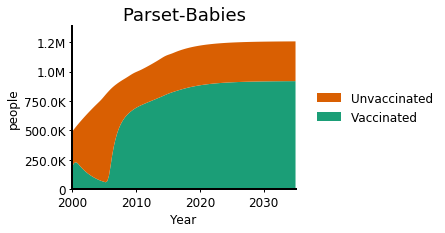

In [29]:
d.pop_names['0-4'] = 'Babies'
d.output_names['sus'] = 'Unvaccinated'
figs = oplt2.plotSeries(d,plot_type='stacked')

### Further formatting

In contrast to the original plotting library, plotting and saving are separate steps. The plotting library functions return arrays containing the handles for figures that they generate. You can use these handles to interact with the plot objects prior to saving them, using any functionality provided by `matplotlib`. Some examples of figure properties you might wish to customize manually are

- Title and axis labels
- Axis ticks and tick labels
- Change marker styles, or unusual hatch patterns
- Change font sizes
- Figure size

An example is shown below

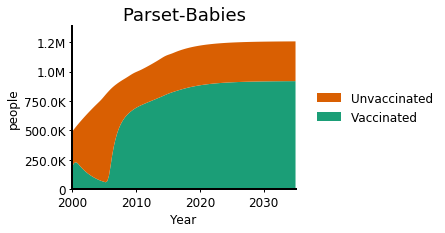

In [30]:
# Default plot
figs = oplt2.plotSeries(d,plot_type='stacked')
ax = figs[0].axes[0]

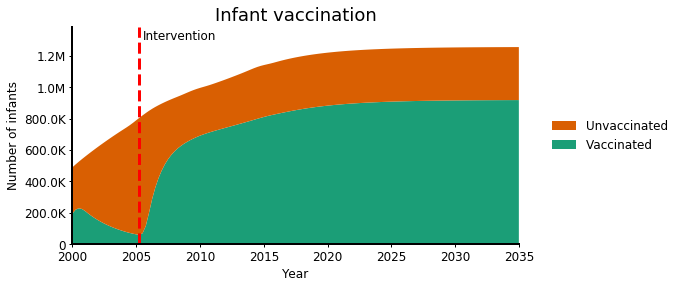

In [31]:
# Customized plot
figs = oplt2.plotSeries(d,plot_type='stacked')
figs[0].set_figwidth(10) # Change width
figs[0].set_figheight(4) # Change height
ax = figs[0].axes[0] # Retrieve the axis handle
ax.set_title('Infant vaccination'); # Set a custom title
ax.set_ylabel('Number of infants'); # Set a custom y axis label
ax.set_xticks(np.arange(2000,2040,5)); # Increase the tick frequency
ax.axvline(x=2005.25,color='r',linestyle='--'); # Highlight a particular time on the plot
ax.text(2005.5,0.94,'Intervention',transform=ax.get_xaxis_transform()); # Put a text annotation

Note that this functionality is mainly intended for figures used in presentations or reports, and so the customization commands would typically be encapsulated inside an application plotting function, rather than being something that is frequently interacted with by end users. It is suggested that this type of customization be one of the final steps in the figure production process.

Note also that because these are raw `matplotlib` commands, searching online for code snippets for how to perform common tasks in `matplotlib` (such as drawing vertical lines or text) will yield results that can be directly used.

### Saving figures

A `matplotlib` figure can always be saved using `fig.savefig(fname)`. For convenience, the plotting library contains a helper function, `save_figs()` that takes in an array of figure handles. By default, the figures will be saved in the current folder, with a file name specified by the figure's `label` property. You can optionally provide a list of filenames, a prefix, and a path with a directory

In [32]:
d = oplt2.PlotData([par_results,prog_results],pops=['0-4','5-14'],outputs=['alive','vac'])
figs = oplt2.plotSeries(d,axis='pops',separate_legend=True)
oplt2.save_figs(figs)
plt.close('all')

26-03-18 10:45:05    INFO     Saved figure "Parset_alive.png"
26-03-18 10:45:05    INFO     Saved figure "Parset_vac.png"
26-03-18 10:45:05    INFO     Saved figure "Progset_alive.png"
26-03-18 10:45:05    INFO     Saved figure "Progset_vac.png"


Notice how the key steps mentioned at the start of this document - data preparation, rendering, (customization), and saving, are reflected in the three function calls i.e.

- Data preparation: `oplt2.PlotData()`
- Figure rendering: `oplt2.plotSeries()`
- Saving: `oplt2.save_figs()`

Notice also how in the example above, the legend figure was not automatically saved. Typically, there may be multiple plots, but only one legend. The file name for the legend thus cannot be automatically determined. Therefore, by default a separate legend will not be saved, unless you give it a label.

In [33]:
figs = oplt2.plotSeries(d,axis='pops',separate_legend=True)
figs[-1].set_label('legend') # If a separate legend is requested, it is always the last figure
oplt2.save_figs(figs)
plt.close('all')

26-03-18 10:45:05    INFO     Saved figure "Parset_alive.png"
26-03-18 10:45:05    INFO     Saved figure "Parset_vac.png"
26-03-18 10:45:05    INFO     Saved figure "Progset_alive.png"
26-03-18 10:45:05    INFO     Saved figure "Progset_vac.png"
26-03-18 10:45:05    INFO     Saved figure "legend.png"


If you specify a path, the figures will be saved inside that folder. If the folder doesn't exist, it will be created

In [34]:
figs = oplt2.plotSeries(d,axis='pops',separate_legend=True)
figs[-1].set_label('legend') # If a separate legend is requested, it is always the last figure
oplt2.save_figs(figs,path='newfolder')
plt.close('all')

26-03-18 10:45:05    INFO     Saved figure "Parset_alive.png"
26-03-18 10:45:05    INFO     Saved figure "Parset_vac.png"
26-03-18 10:45:05    INFO     Saved figure "Progset_alive.png"
26-03-18 10:45:05    INFO     Saved figure "Progset_vac.png"
26-03-18 10:45:05    INFO     Saved figure "legend.png"


Similarly, you can specify a prefix to prepend to all figures being saved

In [35]:
figs = oplt2.plotSeries(d,axis='pops')
figs[-1].set_label('legend') # If a separate legend is requested, it is always the last figure
oplt2.save_figs(figs,path='newfolder',prefix='example')
plt.close('all')

26-03-18 10:45:06    INFO     Saved figure "exampleParset_alive.png"
26-03-18 10:45:06    INFO     Saved figure "exampleParset_vac.png"
26-03-18 10:45:06    INFO     Saved figure "exampleProgset_alive.png"
26-03-18 10:45:06    INFO     Saved figure "examplelegend.png"


Lastly, you can manually specify all of the names you want to use, overriding the default names. In that case, you don't need to set the `label` of the legend figure, because the figure name is being explicitly specified

In [36]:
figs = oplt2.plotSeries(d,axis='pops',separate_legend=True)
oplt2.save_figs(figs,path='newfolder',prefix='series_',fnames=['a','b','c','d','legend'])
plt.close('all')

26-03-18 10:45:06    INFO     Saved figure "series_a.png"
26-03-18 10:45:06    INFO     Saved figure "series_b.png"
26-03-18 10:45:06    INFO     Saved figure "series_c.png"
26-03-18 10:45:06    INFO     Saved figure "series_d.png"
26-03-18 10:45:06    INFO     Saved figure "series_legend.png"


### Plotting bars

The second primary plot type in Optima TB is the bar graph, implemented by `plotBars`. In contrast to `plotSeries`, `plotBars` will only ever return one figure. This means that whatever data is present in the `PlotData` object will be displayed in the figure. As mentioned before, `PlotData` is 4 dimensional. In `plotBars`, these dimensions are represented in the following ways:

- Outputs and Populations are shown as bars, that are distinguished by colour, and appear immediately adjacent to each other. For a single result and time, the output/population bars are referred to as a 'block'
- Results and Times are shown by grouping the bars. The 'inner group' corresponds to which blocks appear next to each other, while the 'outer' group specifies how the blocks are grouped

This is best illustrated using an example. First, unlike with `plotSeries`, it is typically necessary to aggregate plot data over time. This is achieved specifying the time binds when constructing the `PlotData` object. The time bins are specified as either a vector of bin edges, as a scalar spacing between bins, or the keyword `'all'` which includes all time points. So for example, if we want to aggregate the data into decade bins, we could use

In [37]:
d = oplt2.PlotData([par_results,prog_results],pops=['0-4','5-14'],outputs=['sus','vac'],t_bins=10)
d.series[0].t_labels

['2000-2010', '2010-2020', '2020-2030']

Alternatively, we might want to aggregate over all time points

In [38]:
d = oplt2.PlotData([par_results,prog_results],pops=['0-4','5-14'],outputs=['sus','vac'],t_bins='all')
d.series[0].vals

array([99165657.46875864])

Or manually specify 5 year bins

In [39]:
d = oplt2.PlotData([par_results,prog_results],pops=['0-4','5-14'],outputs=['sus','vac'],t_bins=np.arange(2005,2045,5))
d.series[0].vals

array([ 8818298.14616683, 14997574.78306239, 16996538.97513718,
       17949485.52441601, 18256165.35161868, 18348424.21563662,
                     nan])

The above example illustrates a key aspect of time aggregation - consistent with all other Python functions, the time aggregation includes times `>=` the lower value, and `<` the upper value. So for example, if the data contains time points

    t = [2000,2000.25,2000.50,2000.75,2001]

Then a time bin `[2000 2001]` would aggregate the first 4 values, but not include `t=2001`. For a typical model run with integer start and finish years, this means that the last data point would typically not be included, because it corresponds to only a partial year. If a bin extends to times before or after the simulation, then the series value will be set to `nan` to reflect the fact that data did not exist for part of the requested bin. 

However, consistent with Python behaviour, if you use `np.arange(2005,2040,5)` then the upper value `2040` will not appear in the resulting range. Thus, if you specify the upper bound as the end of the time series, and the time span is an integer multiple of the bin size, then the final bin will not be created. For instance, the simulation performed here goes from `2000-2035` so

- `np.arange(2005,2035,5) = array([2005, 2010, 2015, 2020, 2025, 2030])` so the last bin, from `2030-2035` is missing
- `np.arange(2005,2040,5) = array([2005, 2010, 2015, 2020, 2025, 2030, 2035])` so the last bin is correct
- `np.arange(2005,2045,5) = array([2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040])` so the final bin is out of bounds

If you simply specify the bin size, e.g. `t_bins = 5` then the middle example will automatically be used. 

_In general, it is easiest to only specify the bin width, as long as you are happy for the bins to start from the first simulation year_

Finally, note that because time aggregation is implemented by `PlotData`, you can apply time aggregation to `plotSeries` as well as `plotBars` e.g. if you want to plot actual annual values.

So, to make our bar graph, we first select the results, pops, and outputs using the `PlotData` constructor, then perform any necessary time aggregation, and finally render the plot using `plotBars`:

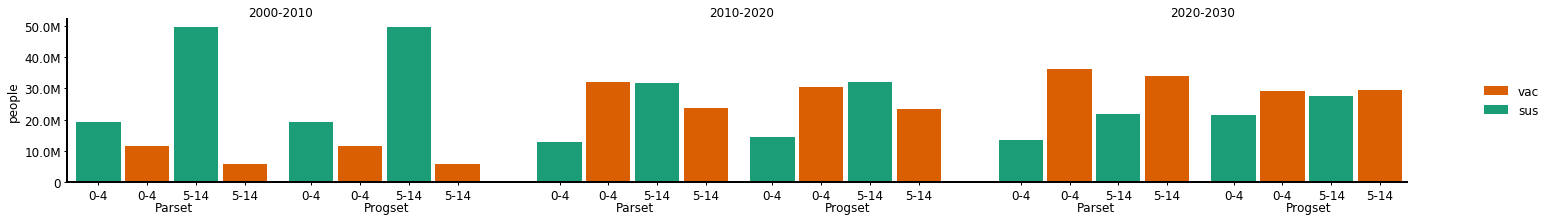

In [40]:
d = oplt2.PlotData([par_results,prog_results],pops=['0-4','5-14'],outputs=['sus','vac'],t_bins=10) # Select data
figs = oplt2.plotBars(d)

The example above illustrates the difference between the 'block', the 'inner group' and the 'outer group'

- The blocks consist of the pops and outputs - the 4 coloured bars correspond to a block
- The 'inner group' is the first level of groupings of the blocks, and the labels for the inner group appear below the plot. The inner groups here are 'Parset' and 'Progset', the names of the results
- The 'outer group' is the higher level of grouping, corresponding to groups-of-inner-groups. The name of the outer group is displayed at the top of the plot. Here, the outer group corresponds to time

You can set the outer group using the `outer` argument, which can be either `'times'` (which is the default), or `'results'`. So to use the results as the outer group, we can use:

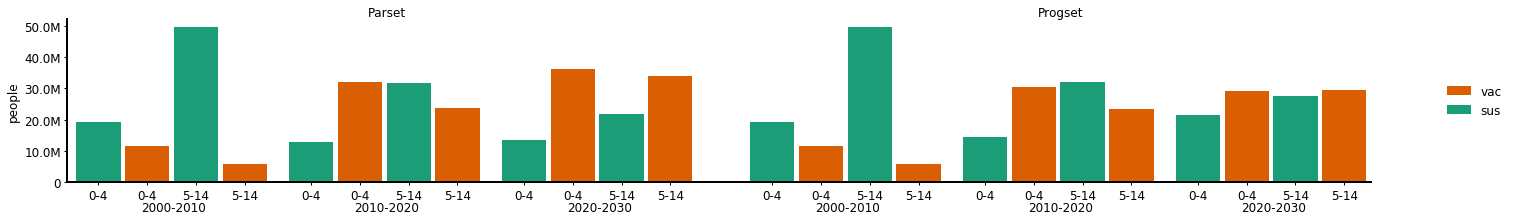

In [41]:
figs = oplt2.plotBars(d,outer='results')

Notice how the labels above and below the graph are now swapped.

Next, we often wish to stack quantities above and below each other. To specify these stackings, you can set the `stack_pops` and `stack_outputs` arguments to `plotBars`. By default, these are lists of all of the pops and outputs in the `PlotData` object. If you want quantities to appear in the same bar, you can specify a list containing the names of the pops and outputs that should appear in the same bar. Two examples are shown below:

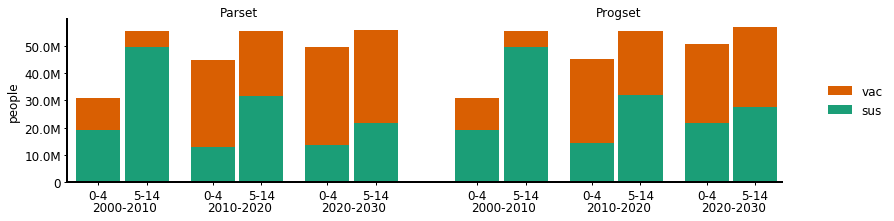

In [42]:
# Stack outputs, to compare population sizes, with a colour breakdown of the vaccination state
figs = oplt2.plotBars(d,outer='results',stack_outputs=[['sus','vac']])

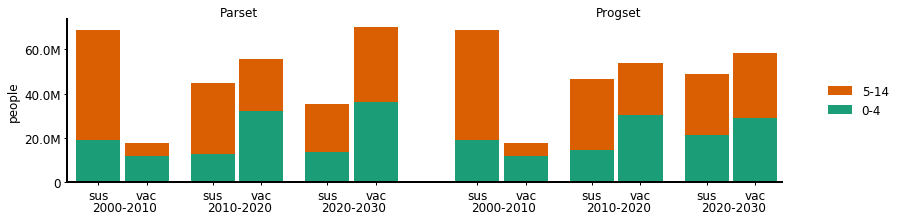

In [43]:
# Stack pops, to compare vaccination states, with a colour breakdown per population
figs = oplt2.plotBars(d,outer='results',stack_pops=[['0-4','5-14']])

If you specify a partial list of stackings, then any pops or outputs that do not appear in the stack will automatically be added as separate unstacked bars. For example, if we have

In [45]:
d = oplt2.PlotData([par_results,prog_results],pops=['0-4','5-14'],outputs=['sus','vac','lt_inf'],t_bins=10)

Then setting `stack_outputs = [['sus','vac']]` is equivalent to `stack_outputs = [['sus','vac'],'lt_inf']`

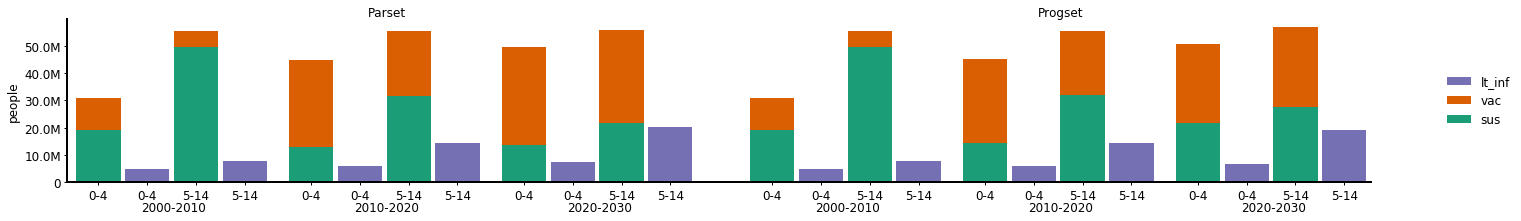

In [46]:
figs = oplt2.plotBars(d,outer='results',stack_outputs=[['sus','vac']])

You can specify an output multiple times if you want it to appear in more than one stack

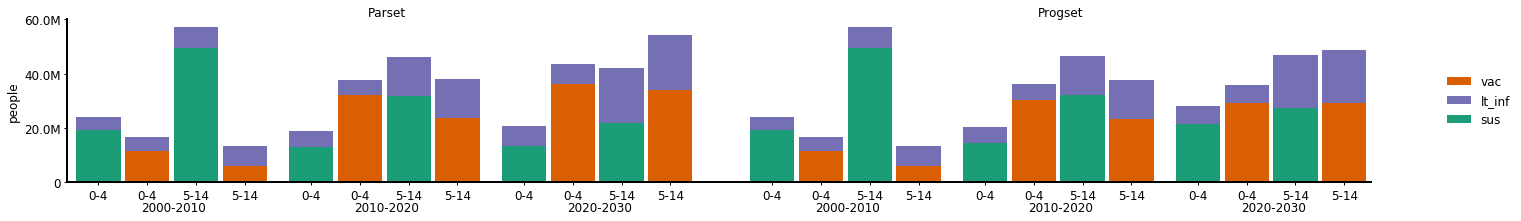

In [47]:
figs = oplt2.plotBars(d,outer='results',stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])

The stacking order is the same as the order of the list that you use to specify the stacks:

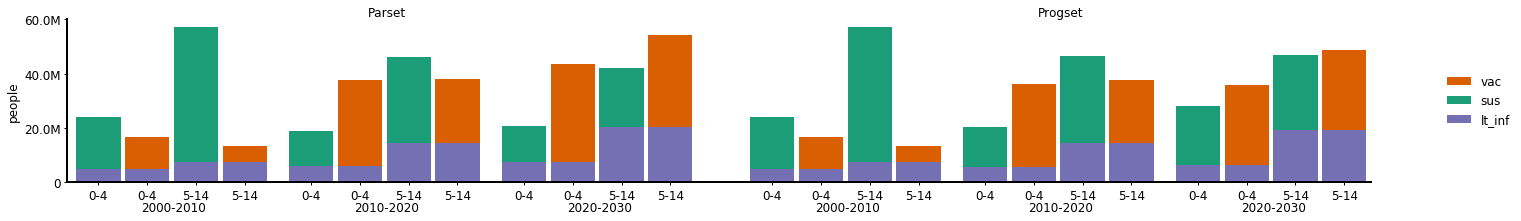

In [48]:
figs = oplt2.plotBars(d,outer='results',stack_outputs=[['lt_inf','sus'],['lt_inf','vac']])

You can also specify multiple levels of stacking, although be aware that this can potentially make the plot difficult to read

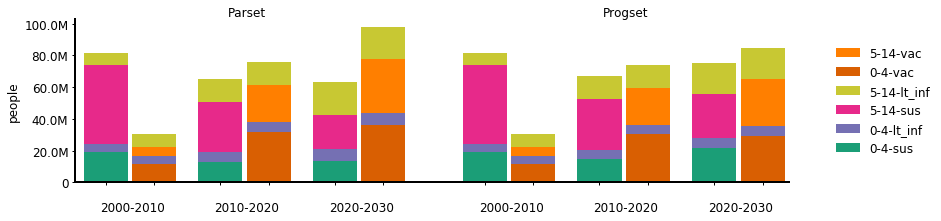

In [49]:
d = oplt2.PlotData([par_results,prog_results],pops=['0-4','5-14'],outputs=['sus','vac','lt_inf'],t_bins=10)
figs = oplt2.plotBars(d,outer='results',stack_pops=[['0-4','5-14']],stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])

Notice how the legend text automatically changes depending on the stacking. If you stack both pops and outputs, then there won't be any text labelling the bars within a block. You can optionally specify `xlabels` to set text labels within the block e.g.

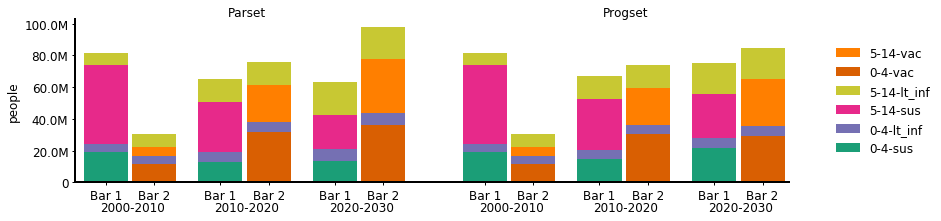

In [50]:
figs = oplt2.plotBars(d,outer='results',stack_pops=[['0-4','5-14']],stack_outputs=[['sus','lt_inf'],['vac','lt_inf']],xlabels=['Bar 1','Bar 2'])

If you want to set custom labels for _every_ bar, then set the `xlabels` for the plot after rendering

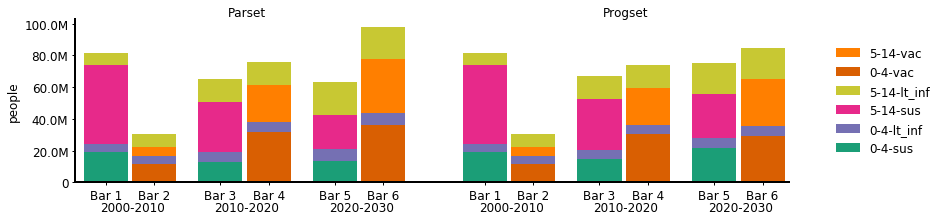

In [51]:
figs = oplt2.plotBars(d,outer='results',stack_pops=[['0-4','5-14']],stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])
ax = figs[0].axes[0]
ax.set_xticklabels(['Bar 1','Bar 2','Bar 3','Bar 4','Bar 5','Bar 6']*2);

### Controlling legend order

By default, the legend order will be determined by the internal plotting order, so it is largely dependent on the order in which you specify the variables. For bar graphs and stacked/proportion series, the legend order is reversed so that the legend matches the visual stacking order. However, in cases where there are complex stacks, like the one above, you might want to have the legend displayed in a different order. To support this, you can use the `reorder_legend` function. This function operates in two ways. First, you can request that the existing order is reversed:

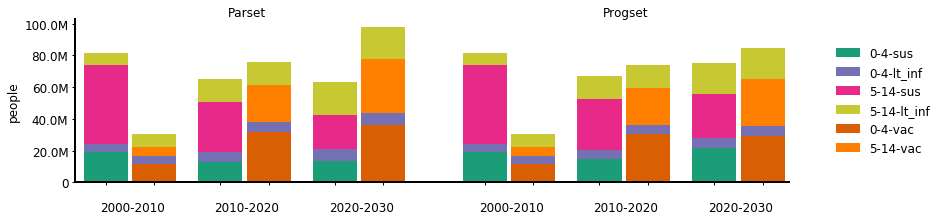

In [52]:
figs = oplt2.plotBars(d,outer='results',stack_pops=[['0-4','5-14']],stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])
oplt2.reorder_legend(figs[0],'reverse')

Notice how the order of the legend is exactly reversed compared to the original plot. However, you might want a more complex reordering e.g. to have the populations appear together in the legend. To achieve this, you can explicitly specify a new ordering for the legend. The input argument is a list, where the index represents the new legend order, and the value indicates the original position. For example, the original plot had the items in the order `[5-14-vac,0-4-vac,5-14-lt_inf,5-14-sus,0-4-lt_inf,0-4-sus]`. If we want the new order to be `[0-4-sus,0-4-vac,0-4-lt_inf,5-14-vac,5-14-sus,5-14-lt_inf]` then we need to specify a list with the original indices of those labels. The first item in that list would be 5, because we want `0-4-sus` to appear first, and its index in the original order was 5. You will need to render and examine the plot first to determine the original index order. So the final order list would be `[5,1,4,3,0,2]` 

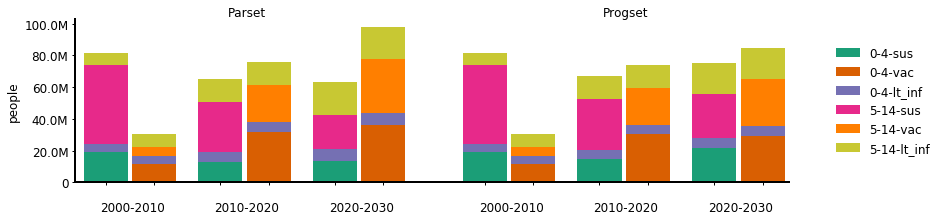

In [53]:
figs = oplt2.plotBars(d,outer='results',stack_pops=[['0-4','5-14']],stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])
oplt2.reorder_legend(figs[0],[5,1,4,3,0,2])

Lastly, you can use the ordering to remove items from the legend by specifying only a partial list

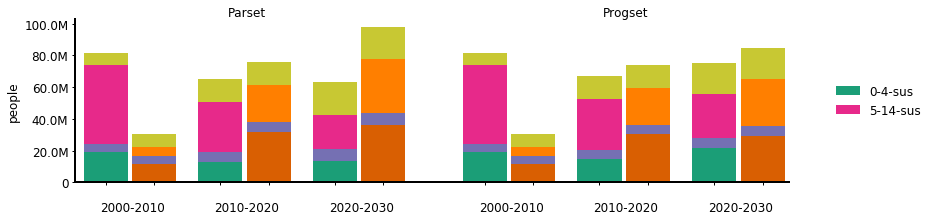

In [54]:
figs = oplt2.plotBars(d,outer='results',stack_pops=[['0-4','5-14']],stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])
oplt2.reorder_legend(figs[0],[5,3])

### Relabeling legend entries



The legend labels are automatically computed. However, you might want to change the legend labels after the fact. To do this, you can use the `relabel_legend` function. This function has two usages. First, if you want to change all labels, you can specify a list of label names the same length as the number of legend items, and they will be applied in order. For example

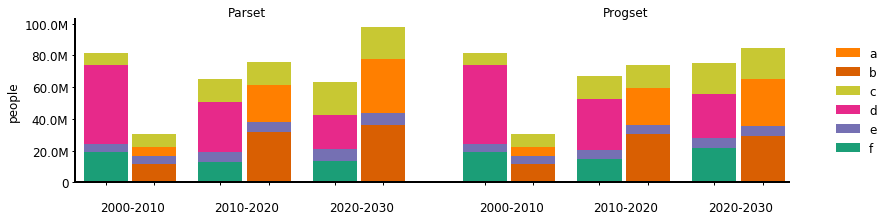

In [55]:
figs = oplt2.plotBars(d,outer='results',stack_pops=[['0-4','5-14']],stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])
oplt2.relabel_legend(figs[0],['a','b','c','d','e','f'])

Alternatively, you can specify a dict where the key is the index of the label you want to change, and the value is the new label name

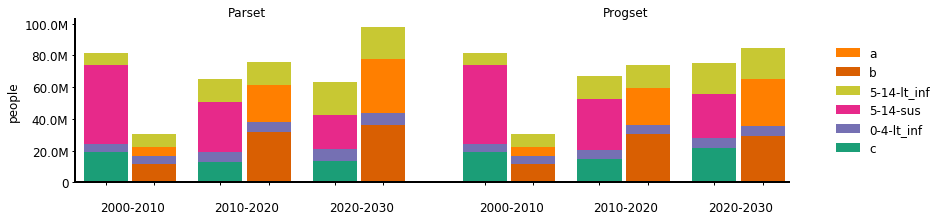

In [56]:
figs = oplt2.plotBars(d,outer='results',stack_pops=[['0-4','5-14']],stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])
oplt2.relabel_legend(figs[0],{0:'a',1:'b',5:'c'})

### Time aggregation of flow rates

Flow rates are computed every timestep, but are normally annualized for plotting. For instance, the plot below of the vaccination rate has units 'People/Year'

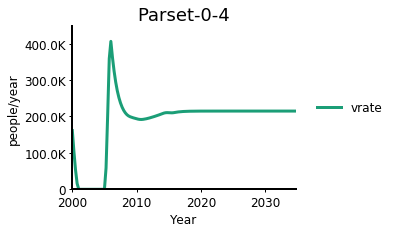

In [57]:
d = oplt2.PlotData(par_results,pops=['0-4'],outputs=['vrate'])
oplt2.plotSeries(d);

However, if we apply a time aggregation, we are typically interested in the number of people transitioning over a period of time. Therefore, we do not want the flow rate to be annualized. If you specify a time aggregation and make a bar plot, note how the axis changes to the total number of people

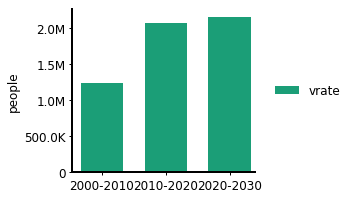

In [74]:
d = oplt2.PlotData(par_results,pops=['0-4'],outputs=['vrate'],t_bins=10)
oplt2.plotBars(d,outer='results');

Note how the plot axis y-label now shows units of 'people' rather than 'people/year'. In particular, note how the flow rate in the line plot is about 200000 people/year between 2020 and 2030. Thus the expected number of people transitioning in the decade from 2020-2030 would be `200000*10=2e6`, and we confirm that the bar graph shows approximately 2 million people have transitioned in that time period.

Lastly, note that if you make a line plot of time-aggregated data, the units will correspond to the time aggregated values, so flow rates will *not* be annualized e.g.

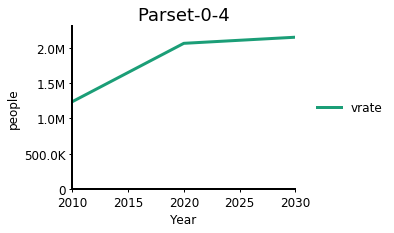

In [75]:
oplt2.plotSeries(d);

Note that the y-axis label changes to indicate this

### Setting colors

A common task is to set colours. This is done by assigning colours to `Series` in the `PlotData` object. These colours are then used by `plotSeries` and `plotBars`. Colours can be assigned in two ways

- You can set the `color` property of a series, which specifies a colour for a `[results,pop,output]` item
- You can set colors for a set of series, such that the color is shared across the other dimensions. For example, you could set a color scheme for `outputs` that is shared across all `results` and `pops`

Setting colours directly via the `color` is typically cumbersome unless automated.

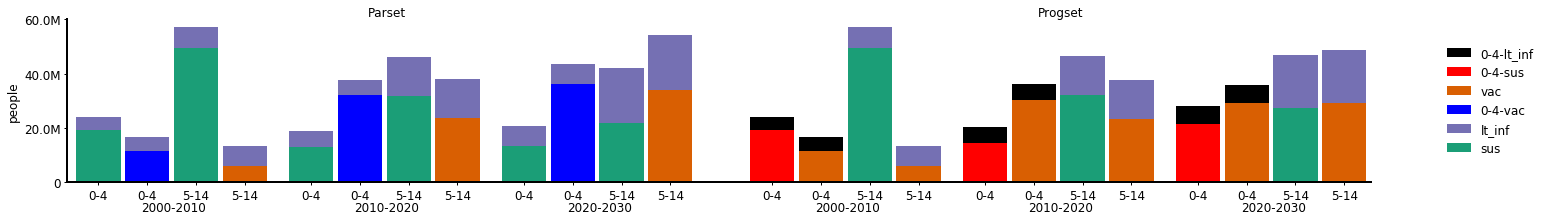

In [59]:
d = oplt2.PlotData([par_results,prog_results],pops=['0-4','5-14'],outputs=['sus','vac','lt_inf'],t_bins=10)
d['Parset','0-4','vac'].color = 'b'
d['Progset','0-4','sus'].color = 'r'
d['Progset','0-4','lt_inf'].color = 'k'
figs = oplt2.plotBars(d,outer='results',stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])

More typically, you would want to set colours for every instance of a result, pop, or output, across all other variables. For instance, you might want to set all of the outputs to the same colour, irrespective of result or pop. This can be done using the `set_colors` method of `PlotData`. You specify a set of filters for `result`, `pop`, and `output`, and a single color or list of colours to apply to the set of `Series` matching the filter. This filtering is best illustrated with some examples.

One important factor to be aware of is that `set_colors` has an optional argument, `overwrite`, which decides whether to preserve manually set colors or not. In the example above, colours were only specified for 3 series. The remaining colours were assigned within `plotBars`. By default, the colour of a series is `None` which means it will be automatically determined when plotted. By default, `set_colors` will only update the colours if the series colour is `None`. 



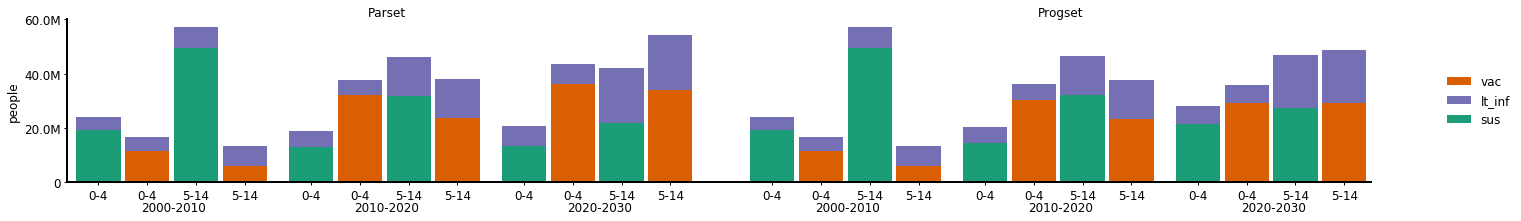

In [60]:
d.set_colors(outputs=d.outputs,overwrite=True) # Set automatic colours on a per-output basis
figs = oplt2.plotBars(d,outer='results',stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])

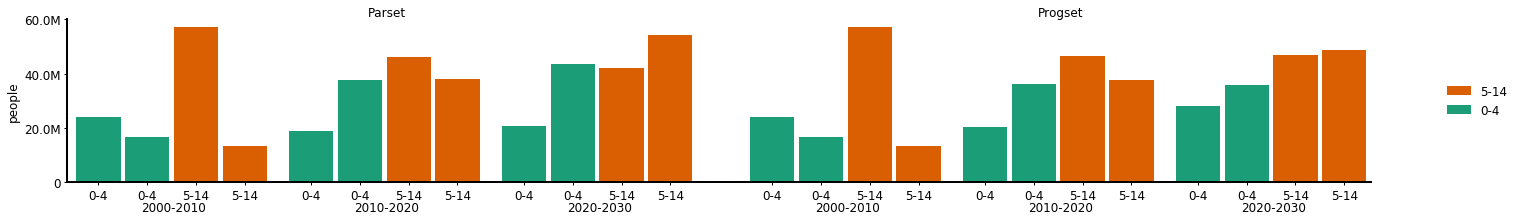

In [61]:
d.set_colors(pops=d.pops,overwrite=True) # Set automatic colours on a per-result basis
figs = oplt2.plotBars(d,outer='results',stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])

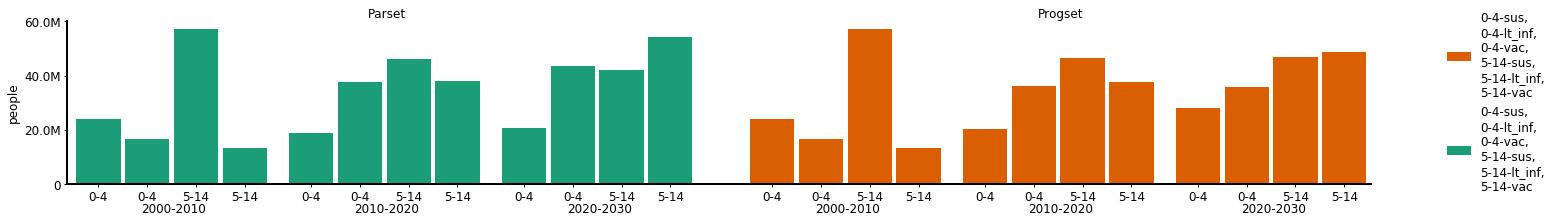

In [62]:
d.set_colors(results=d.results,overwrite=True) # Set automatic colours on a per-result basis
figs = oplt2.plotBars(d,outer='results',stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])

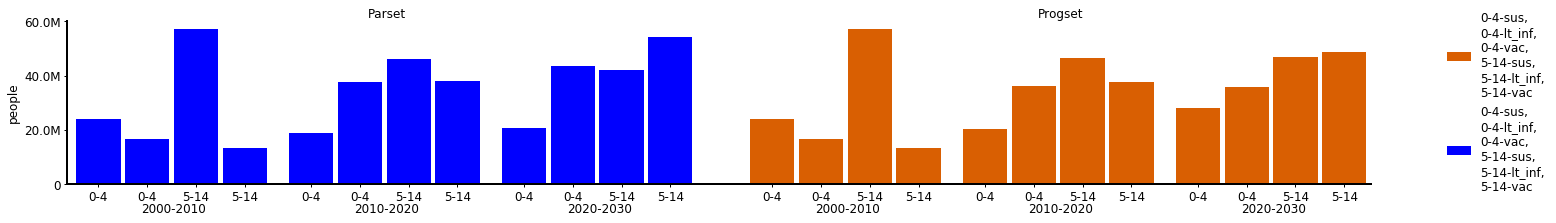

In [63]:
# Filter based on only result
d.set_colors('b',results=['Parset'],overwrite=True) # Set all bars in 'Parset' to blue
figs = oplt2.plotBars(d,outer='results',stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])

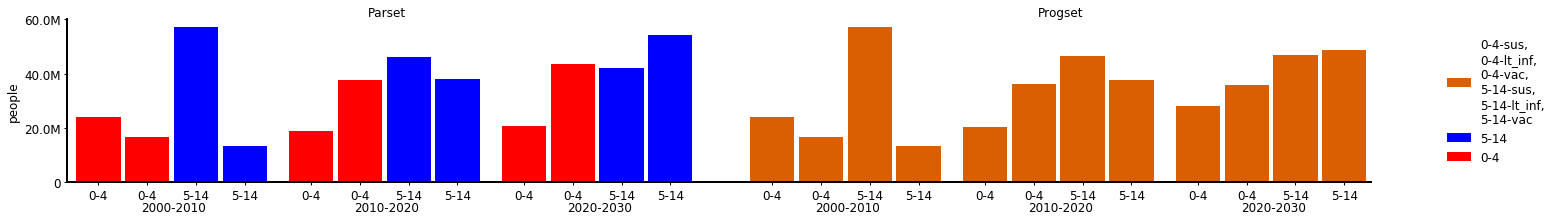

In [64]:
# Filter based on both result and pops
d.set_colors('r',results=['Parset'],pops=['0-4'],overwrite=True) # Set all bars in 'Parset' to blue
figs = oplt2.plotBars(d,outer='results',stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])

If your filter matches more than one quantity, and the colour is either the name of a colormap or a list of colours, then colours from that set will be distributed and assigned to the specified items. For example

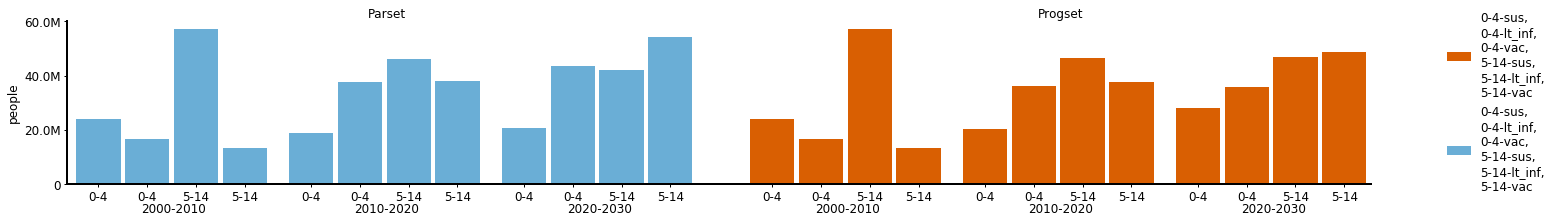

In [65]:
# Only one result is specified, so only one colour will be used
d.set_colors('Blues',results=['Parset'],overwrite=True) # Set all bars in 'Parset' to blue
figs = oplt2.plotBars(d,outer='results',stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])

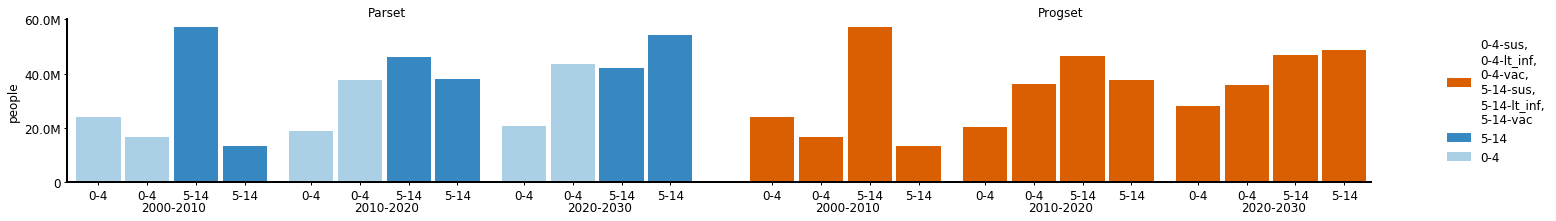

In [66]:
# 1 result and 2 pops are specified, so 1x2=2 colours will be used
d.set_colors('Blues',results=['Parset'],pops=d.pops,overwrite=True) # Set all bars in 'Parset' to blue
figs = oplt2.plotBars(d,outer='results',stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])

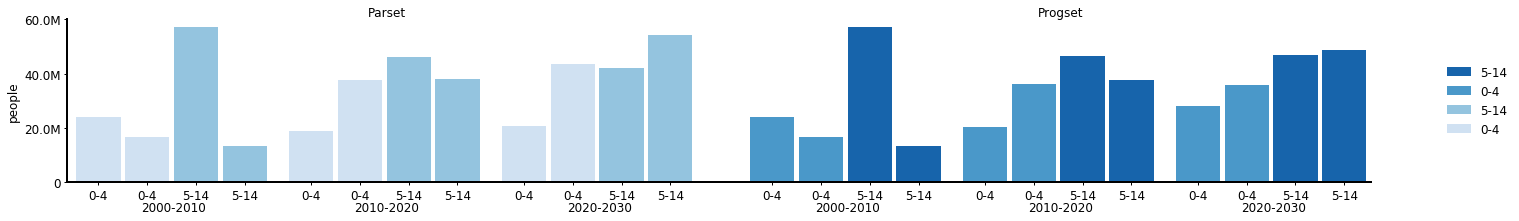

In [67]:
# 2 results and 2 pops are specified, so 2x2=4 colours will be used
d.set_colors('Blues',results=d.results,pops=d.pops,overwrite=True) # Set all bars in 'Parset' to blue
figs = oplt2.plotBars(d,outer='results',stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])

Note that you can call `set_colors` multiple times on different subsets of the `series` to build up a complex colour scheme. This can be especially useful if you have a complex stacking arrangement. Suppose we wanted to break down the vaccination status of each population, for all populations, at three points in time. We would accomplish this as follows

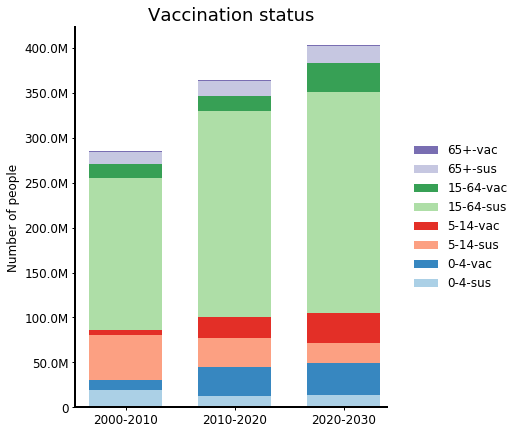

In [68]:
d = oplt2.PlotData(par_results,pops=['0-4','5-14','15-64','65+'],outputs=['sus','vac'],t_bins=10) # Retrieve all of the data
d.set_colors('Blues',pops=['0-4'],outputs=d.outputs) # Set a colour scheme for 0-4 but still separating vac and sus
d.set_colors('Reds',pops=['5-14'],outputs=d.outputs) # Use a different colour scheme for 5-14 
d.set_colors('Greens',pops=['15-64'],outputs=d.outputs)
d.set_colors('Purples',pops=['65+'],outputs=d.outputs)
figs = oplt2.plotBars(d,stack_pops=[d.pops],stack_outputs=[d.outputs],outer='results')
# Perform some additional post-plotting customization
figs[0].set_figwidth(7)
figs[0].set_figheight(7)
ax = figs[0].axes[0]
ax.set_title('Vaccination status');
ax.set_ylabel('Number of people');

Note that if there are no block labels and the number of inner group labels is the same as the number of bars, then the inner group labels will be 'promoted' to axis tick labels. This will not happen:

- For outer group labels
- If any block labels are specified

On the other hand, the outer label will only be displayed if there is more than one outer group. Thus, some other label alternatives for this plot then are:

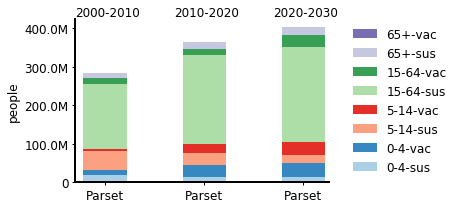

In [69]:
figs = oplt2.plotBars(d,stack_pops=[d.pops],stack_outputs=[d.outputs],outer='times')

There is only one result, 'Parset', so when the results are used as the outer grouping, it is not shown. But when the results are the inner group, then the label will be shown. As there are no bar labels, the inner group labels are promoted to axis labels, as before. 

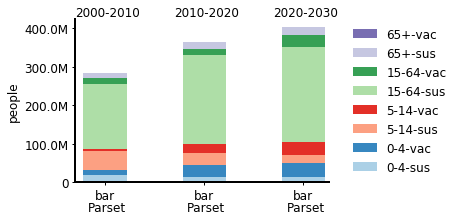

In [70]:
figs = oplt2.plotBars(d,stack_pops=[d.pops],stack_outputs=[d.outputs],outer='times',xlabels=['bar'])

Now, the inner group label is shown below the manually specified axis tick labels

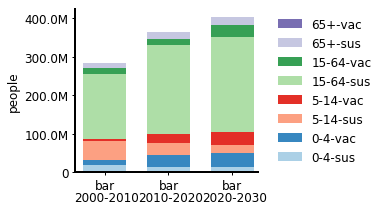

In [71]:
figs = oplt2.plotBars(d,stack_pops=[d.pops],stack_outputs=[d.outputs],outer='results',xlabels=['bar'])

Now, the inner group labels are still shown below the block labels, but there is no outer label because there is only one outer group. Lastly, note that this colour system also applies to `plotSeries`, and because the colours are stored in `PlotData` they are automatically applied if you use `plotSeries` to view the data:

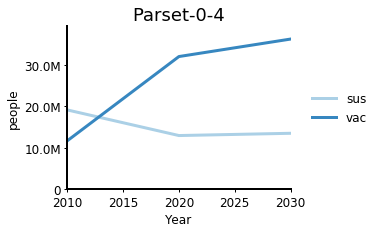

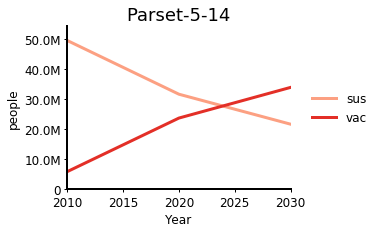

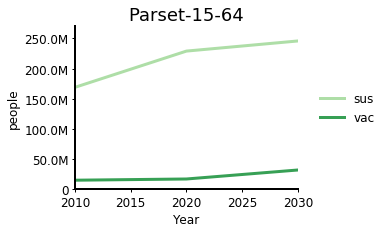

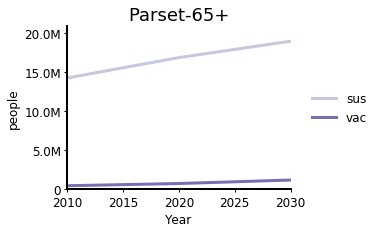

In [72]:
figs = oplt2.plotSeries(d)

although the example looks a bit unusual because there are only 3 timepoints (as the `PlotData` object was temporally-aggregated)

### Colour design patterns

One way to reuse colours across a project is by writing a function that contains the appropriate `set_color` calls to assign colours to a `PlotData` object. So for instance, instead of

```python
def getColormappingsBySmear():
    cat_list = odict()
    cat_list['#005B9A'] = ['sus']
    cat_list['#0191C8'] = ['vac']
    cat_list['Purples'] = ['lteu', 'ltlu', 'lted', 'ltet', 'ltld', 'ltlt']
    cat_list['Oranges'] = ['spdu', 'spdd', 'spdt', 'spmu', 'spmd', 'spmt', 'spxu', 'spxd', 'spxt']
    cat_list['Greens'] = ['acr', 'ltr']
    labels = ['Susceptible', 'Vaccinated', 'Latent TB', 'Active TB (S+)', 'Active TB (S-)', 'Recovered']
    return cat_list, labels
```

you might instead have

```python
def setColormappingsBySmear(plotdata):
    plotdata.set_color('#005B9A',outputs=['sus']
    plotdata.set_color('#0191C8',outputs=['vac']
    plotdata.set_color('Purples',outputs=['lteu', 'ltlu', 'lted', 'ltet', 'ltld', 'ltlt']
    plotdata.set_color('Reds',outputs=['sndu', 'sndd', 'sndt', 'snmu', 'snmd', 'snmt', 'snxu', 'snxd', 'snxt']
    plotdata.set_color('Greens',outputs=['acr', 'ltr']
```

This would modify a `PlotData` instance in-place, so it could be plotted afterwards with the appropriate colour scheme e.g.

```python
d = oplt2.PlotData(results,...)
setColormappingsBySmear(d)
oplt2.plotSeries(d) # Will use custom colour scheme
```

### Stacking vs. Aggregation

An _aggregation_ maps multiple time series onto a single quantity, while _stacking_ puts two quantities in the same bar. A general rule of thumb is that an _aggregation_ should be used if you want the two quantities to share the same colour, while _stacking_ should be used if the quantities need to be visually disaggregated.